In [ ]:
#from shrink_dataset import extract_datasets
#extract_datasets()

In [16]:
import wandb
from evaluate_task import Task
GPT3_5 = "gpt-3.5-turbo-0125" #metti la preview
GPT4 = "gpt-4-0125-preview"

anachronism = Task('multiple_choice',
                   'datasets/task_anachronisms.json',
                   'Does the following sentence contain non-contemporaneous (anachronistic) elements?.')
logical_sequence = Task('multiple_choice',
                        'datasets/task_logical_sequence.json',
                        "Identify the correct chronological or sequential order of items in a list.")
color_HCL = Task('multiple_choice', 'datasets/task_color_HCL.json',"")
color_RGB = Task('multiple_choice', 'datasets/task_color_RGB.json',"")
color_HEX = Task('multiple_choice', 'datasets/task_color_HEX.json',"")
color_HSL = Task('multiple_choice', 'datasets/task_color_HSL.json',"")
matrixshapes = Task('free_response',
                    'datasets/task_matrixshapes.json',
                    "Compute the final matrix shape after the given operations are performed.")
operators = Task('free_response',
                    'datasets/task_operators.json',
                    "Given the definition of the op operator, compute the result.")


In [ ]:
#BASELINE

MULTIPLE_CHOICE_SUFFIX = "Just repeat the answer you choose."
FREE_RESPONSE_SUFFIX = "Please don't show me the steps, i just want to see the final result in one single line."

In [ ]:
#WITH EXPLANATION

MULTIPLE_CHOICE_SUFFIX = "First you explain your answer in 50 words, in the last line you answer just repeating the answer you choose."
FREE_RESPONSE_SUFFIX = "First you explain your answer in 50 words, in the last line you answer just the result."


In [ ]:
#CHAIN OF THOUGHTS

MULTIPLE_CHOICE_SUFFIX = "Split the problem in steps, resolve the steps and then in the last line you just repeat the answer you choose."
FREE_RESPONSE_SUFFIX = "Split the problem in steps, resolve the steps and then in the last line answer just the result."

In [ ]:
#FEW-SHOTS

#starting from the baseline suffixes
MULTIPLE_CHOICE_SUFFIX = "Just repeat the answer you choose."
FREE_RESPONSE_SUFFIX = "Please don't show me the steps, i just want to see the final result in one single line."

for task in [anachronism, logical_sequence, color_HCL, color_RGB, color_HEX, color_HSL, matrixshapes, operators]:

    wandb.init(project="LLMs-Still-Can-t",config={"model": GPT4,"shots": 5})

    suffix = MULTIPLE_CHOICE_SUFFIX if task.type == 'multiple_choice' else FREE_RESPONSE_SUFFIX
    acc , df = task.evaluate(wandb.config.model, suffix, wandb.config.shots)

    wandb.log({ "accuracy": acc, "examples": wandb.Table(dataframe=df)})

    wandb.run.summary["system_prompt"] = task.system_prompt + suffix
    wandb.run.summary["model"] = wandb.config.model
    wandb.run.summary["shots"] = wandb.config.shots
    wandb.run.summary["name"] = f"Baseline [{task.json_string}]"

    wandb.finish()


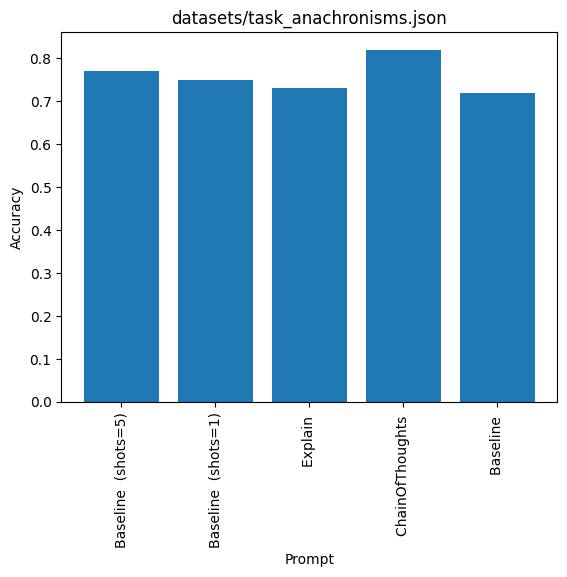

In [20]:
#PLOTTING
import matplotlib.pyplot as plt

api = wandb.Api()
runs = api.runs("simone-bresciani/LLMs-Still-Can-t")

def plot_task(task):
    x = []
    y = []
    for run in [run for run in runs if task.json_string in run.summary['name']]:
        name = run.summary['name'].split('[')[0]
        shots = run.config['shots']
        accuracy = run.summary['accuracy']
        x.append(name) if shots == 0 else x.append(f'{name} (shots={shots})')
        y.append(accuracy)
    plt.bar(x, y)
    plt.xlabel('Prompt')
    plt.ylabel('Accuracy')
    plt.xticks(rotation=90)
    plt.title(task.json_string)
    plt.show()

plot_task(anachronism)

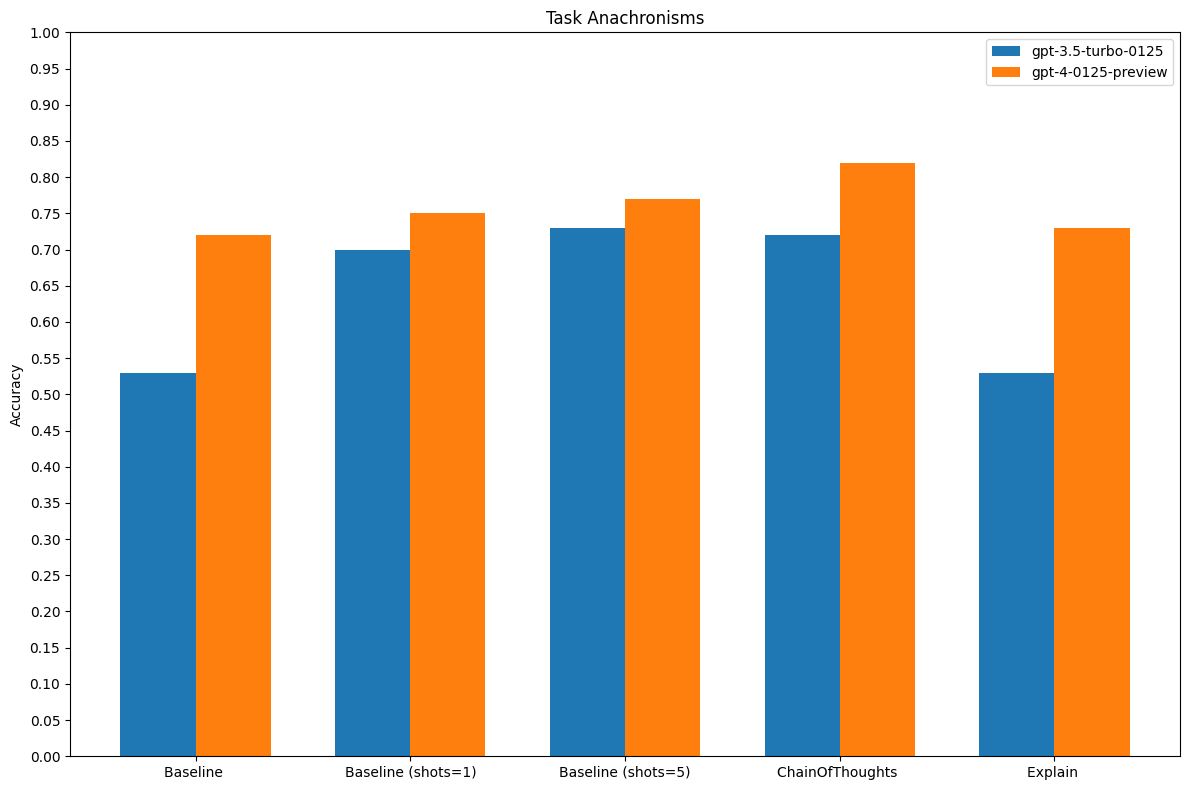

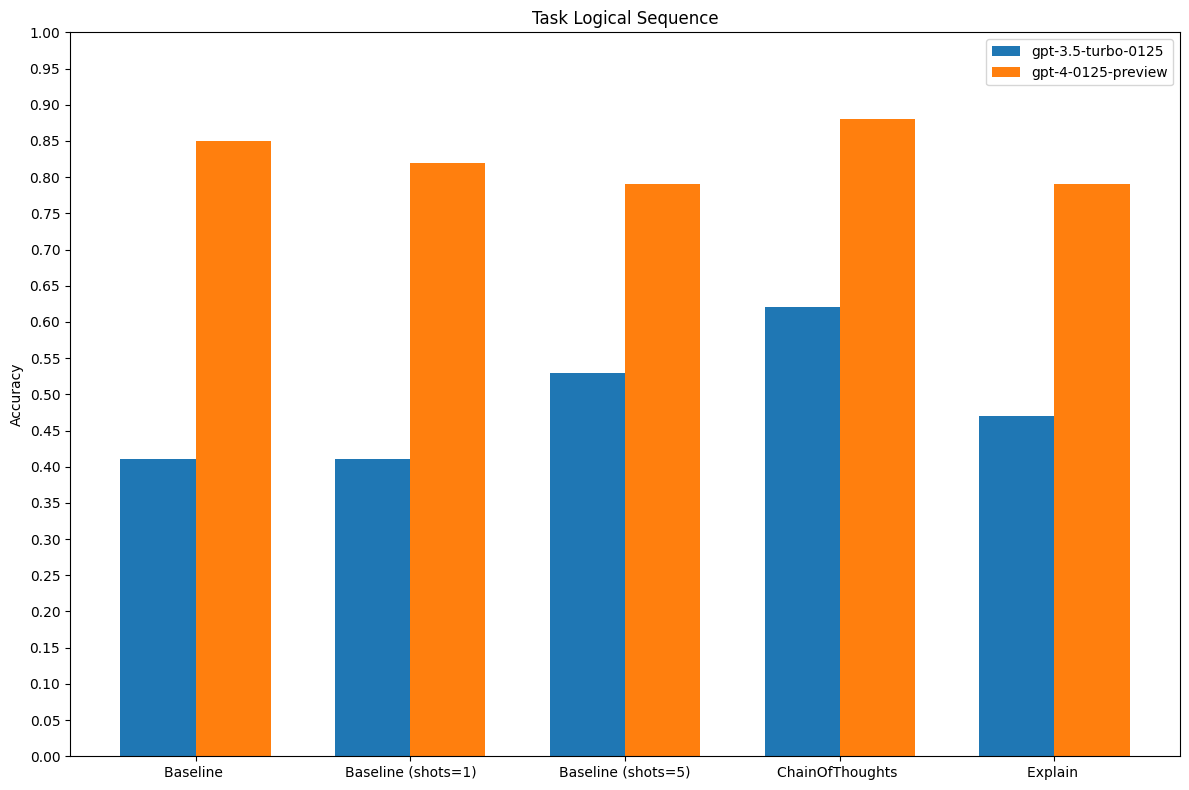

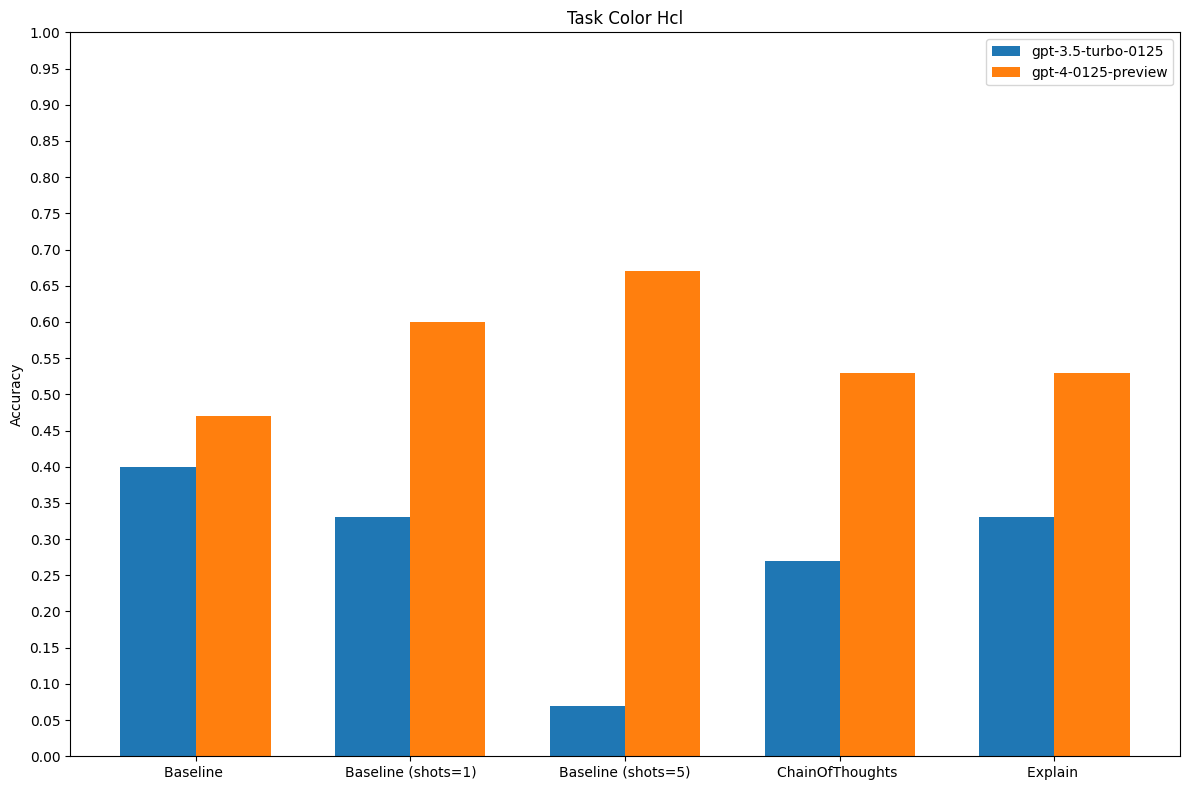

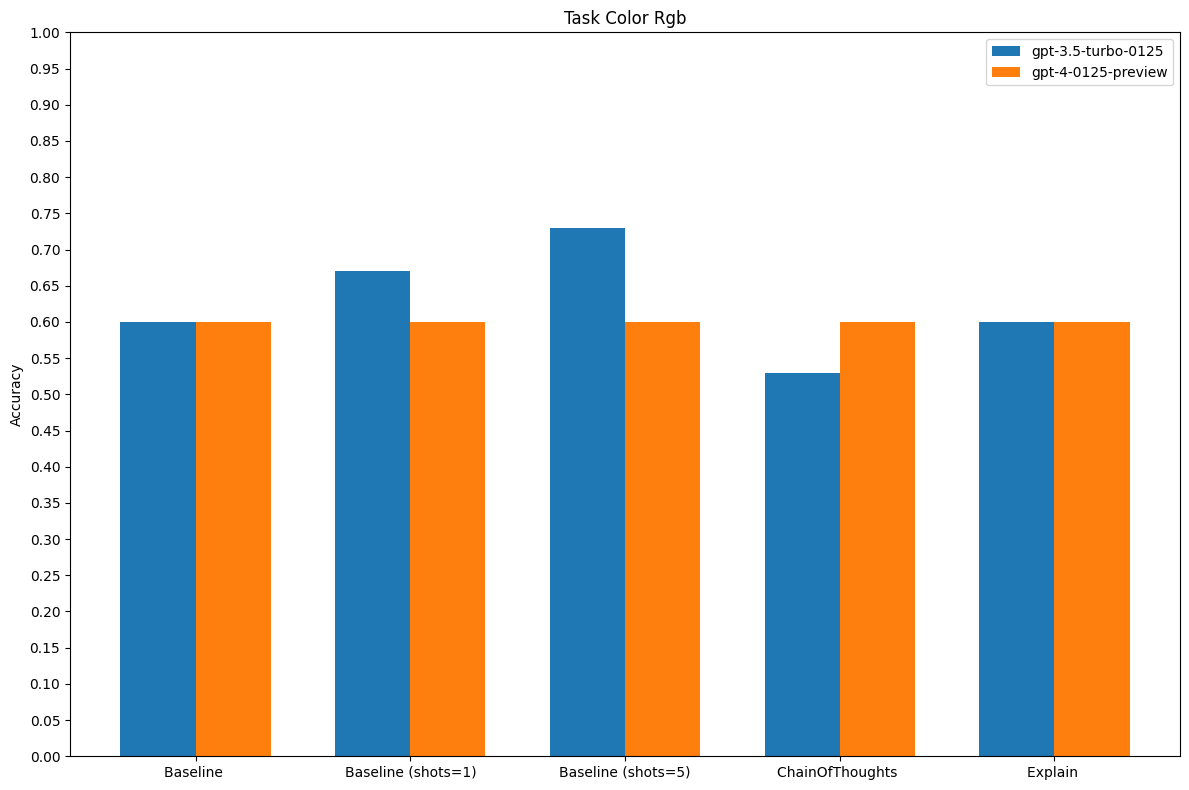

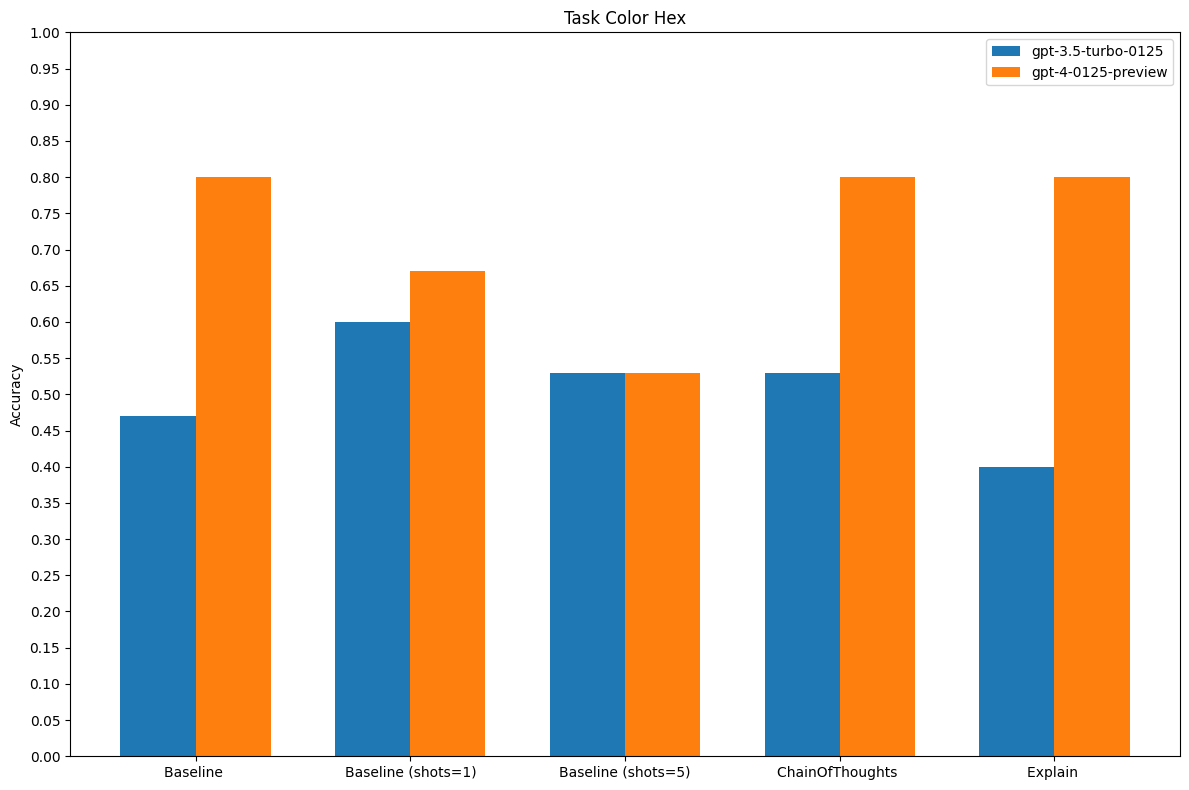

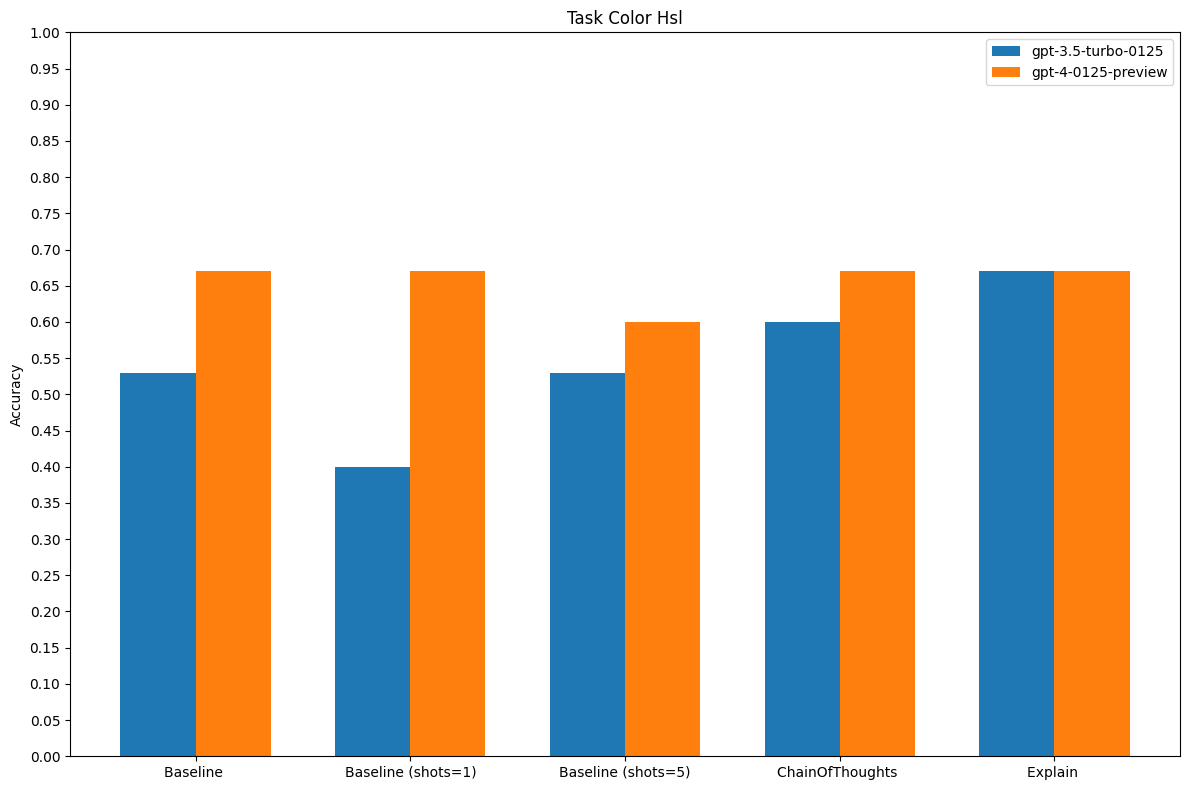

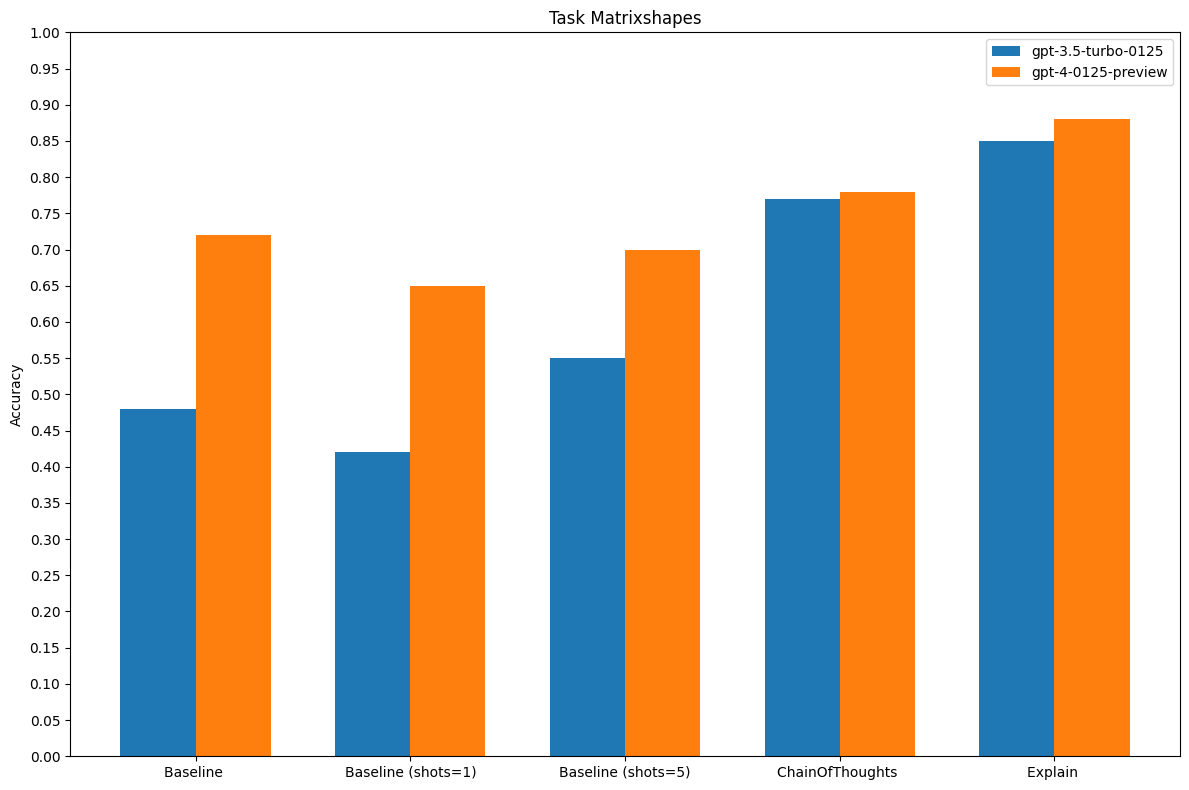

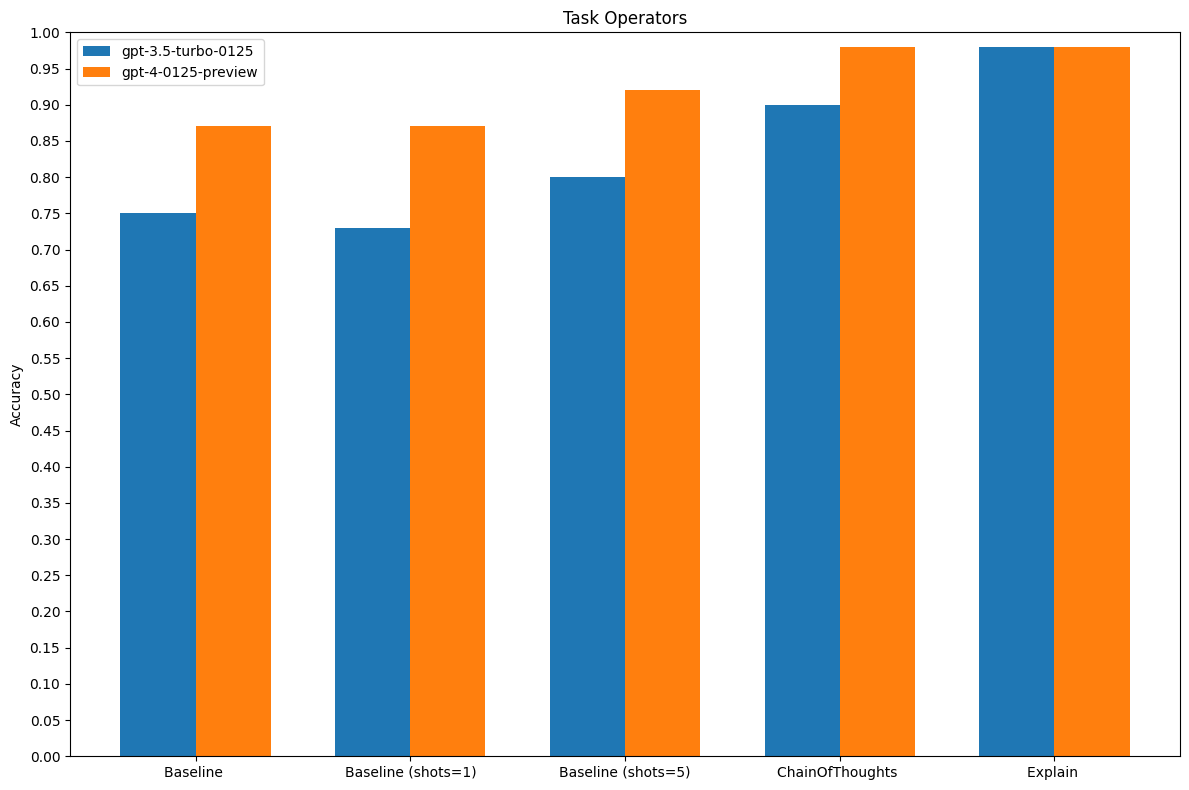

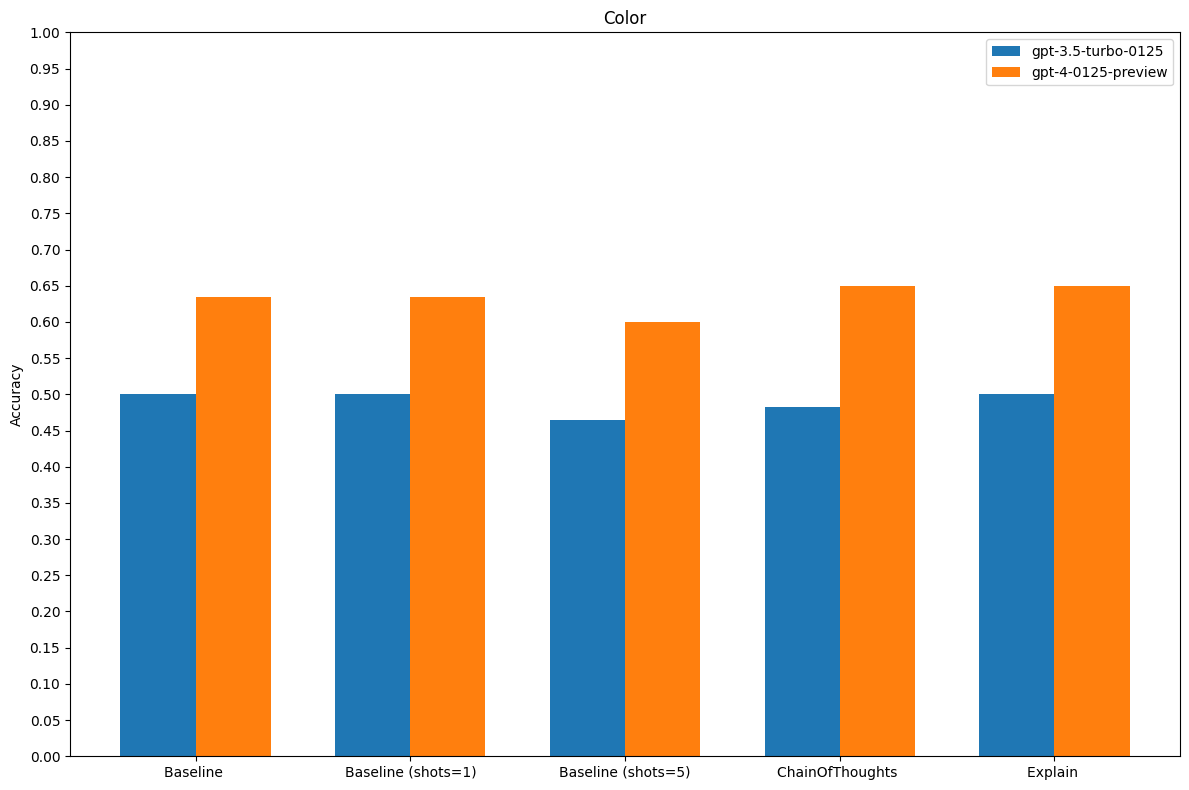

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import wandb

# Initialize the API
api = wandb.Api()

# Specify the project path (in the format "username/project")
project_path = "simone-bresciani/LLMs-Still-Can-t"
runs = api.runs(project_path)

def print_plot(data, title):
    keys = sorted(data.keys())
    models = sorted(set(model for values in data.values() for model in values.keys()))

    x = np.arange(len(keys))

    plt.figure(figsize=(12, 8))
    width = 0.35  # Width of the bars
    for i, model in enumerate(models):
        accuracies = [data[key].get(model, 0) for key in keys]
        plt.bar(x - width/2 + i*width, accuracies, width, label=model)

    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xticks(x,keys)
    plt.yticks(np.arange(0, 1.1, 0.05))  # Set the y-axis ticks from 0 to 1 with a step of 0.1
    plt.ylim(0, 1)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_task(task):
    data = {}
    for run in [run for run in runs if task.json_string in run.summary['name']]:
        name = run.summary['name'].split('[')[0]
        shots = run.summary['shots'] 
        model = run.summary['model'] 
        accuracy = run.summary['accuracy']  
        key = name if shots == 0 else f'{name}(shots={shots})'
        if key not in data:
            data[key] = {}
        data[key][model] = accuracy
    print_plot(data, task.json_string.split('/')[1].split('.')[0].replace('_', ' ').title())


def plot_color_mean():
    data = {}
    for run in [run for run in runs if 'color' in run.summary['name']]:
        name = run.summary['name'].split('[')[0]
        shots = run.summary['shots'] 
        model = run.summary['model'] 
        sum = 0
        for type in [run for run in runs if 'color' in run.summary['name'] and name in run.summary['name'] and shots == run.summary['shots'] and model == run.summary['model']]:
            sum += type.summary['accuracy']
        accuracy = sum / 4
        key = name if shots == 0 else f'{name}(shots={shots})'
        if key not in data:
            data[key] = {}
        data[key][model] = accuracy
    print_plot(data, 'Color')
    

for task in [anachronism, logical_sequence, color_HCL, color_RGB, color_HEX, color_HSL, matrixshapes, operators]:
    plot_task(task)
plot_color_mean()


In [ ]:
#baseline
#explain
#chain of thoughts (che valga per tutte le task)
#few-shots(1 e 5) bilancia i gli shots: devono contenere più scelte possibili, non solo una.

#matplot lib per fare i grafici delle accuracy: per ogni task crea un grafico con accuracy in ascisse e prompt in asse
#fanne due per ogni task cambiando il modello e metti in grafico a doppia barra.
